In [6]:
# !pip install multiprocess
# !pip install pyreadr
# !git clone https://github.com/maxhuppertz/hdmpy.git

In [2]:
import hdmpy
import patsy
import warnings
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from collections import defaultdict

warnings.simplefilter('ignore')

In [3]:
sample_sizes = [50, 150, 250, 350, 450, 550, 650, 750]
d = 10 
p = 0.2  
delta = 1 
base =0.3


# A simple experimental data generating process
def gen_data(n, d, p, delta, base):
    D = np.random.binomial(1, p, size=(n,))
    X = np.random.normal(0, 1, size=(n, d))
    y0 = base - X[:, 0] + np.random.normal(0, 1, size=(n,))
    y1 = delta + base - X[:, 0] + np.random.normal(0, 1, size=(n,))
    y = y1 * D + y0 * (1 - D)
    return y, D, X


In [4]:
class RLasso(BaseEstimator):
    
    def __init__(self, *, post=False):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    @property
    def coef_(self):
        return np.array(self.rlasso_.est['beta']).flatten()

    def predict(self, X):
        return X @ self.coef_ + np.array(self.rlasso_.est['intercept'])

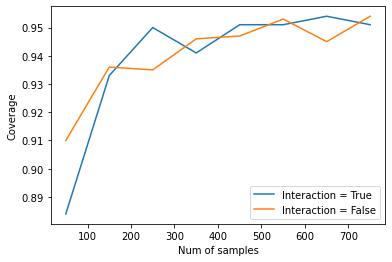

In [5]:
def double_Rlasso(y, D, W):
    yres = y - RLasso().fit(W, y).predict(W)   ### Replace LASSO-CV with RLasso
    Dres = D - RLasso().fit(W, D).predict(W)   ### Replace LASSO-CV with RLasso
    hat = np.mean(yres * Dres) / np.mean(Dres**2)
    epsilon = yres - hat * Dres
    V = np.mean(epsilon**2 * Dres**2) / np.mean(Dres**2)**2
    return hat, np.sqrt(V / y.shape[0])
    


np.random.seed(42)
p = 0.2
def get_coverage_RLASSO(sample_sizes, d, p, delta, base, trials, interaction):
    coverage = {}
    for sample_size in sample_sizes:
        cov = []
        for _ in range(trials):
            y, D, X = gen_data(sample_size, d, p, delta, base)
            X = X-X.mean(axis=0)
            if not interaction: 
                hat, stderr = double_Rlasso(y, D, X)
            else:
                hat, stderr = double_Rlasso(y, D, np.hstack([D.reshape(-1,1)*X, X]))
            ci = [hat - 1.96 * stderr, hat + 1.96 * stderr]
            cov += [(ci[0] <= delta) & (delta <= ci[1])] 
        coverage[sample_size] = np.mean(cov)
    return coverage


interactions = [True, False]

for interaction in interactions:

    coverage = get_coverage_RLASSO(p=p, sample_sizes=sample_sizes, d=d, delta=delta, base=base, trials=1000, interaction=interaction)
    lists = sorted(coverage.items()) 
    x, y = zip(*lists) 
    plt.plot(x, y, label = f'Interaction = {interaction}')
    plt.xlabel("Num of samples")
    plt.ylabel("Coverage")
    plt.legend()